# Analyse the energy data for the University of Edinburgh campuses

Author: Daniel Friedrich

Edited: Andrew Lyden

In [47]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

### Select file for analysis

In [164]:



get_easter_bush_demand()


C:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



(                     Values
 2018-08-01 00:30:00   200.0
 2018-08-01 01:00:00   201.0
 2018-08-01 01:30:00   199.0
 2018-08-01 02:00:00   200.0
 2018-08-01 02:30:00   300.0
 ...                     ...
 2020-05-14 22:00:00   300.0
 2020-05-14 22:30:00   400.0
 2020-05-14 23:00:00     0.0
 2020-05-14 23:30:00     0.0
 2020-05-15 00:00:00     0.0
 
 [31344 rows x 1 columns],
                      Values
 2018-11-01 00:30:00     0.0
 2018-11-01 01:00:00     0.0
 2018-11-01 01:30:00     0.0
 2018-11-01 02:00:00     0.0
 2018-11-01 02:30:00     0.0
 ...                     ...
 2020-05-31 22:00:00     0.0
 2020-05-31 22:30:00     0.0
 2020-05-31 23:00:00     0.0
 2020-05-31 23:30:00     0.0
 2020-06-01 00:00:00     0.0
 
 [27744 rows x 1 columns])

In [74]:
# Define path of the data file
# filename = 'AMR_Data_for_meter_0638NE001V_KB Elec.XLSX'
filename = 'AMR_Data_for_meter_0795NE003V_Easter Bush Elec.XLSX'
# filename = 'AMR_Data_for_meter_0795NH001S_Easter Bush Heat.XLSX'

### Seaborn layout for the plots

In [75]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(16, 5)})

### Function to parse different datetime formats

In [76]:
def try_parsing_date(text):
    """
    Parse dates with different formats.
    
    This is required to correctly parse the dates in the gridwatch data.
    """
    for fmt in ("%Y-%m-%d %H:%M", "%Y-%m-%d %H:%M:%S", "%d/%m/%Y %H:%M", " %Y-%m-%d %H:%M:%S", "%d/%m/%Y"):
        try:
             return datetime.datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError("No valid date format found.")

### Read the Excel spreadsheet data

In [77]:
# Set path to the current directory
cwd = os.getcwd()
# filename is chosen earlier, see "select file for analysis" where filename string is defined
absolute_path = os.path.join(cwd, 'UoE_energy_data', 'UoE_energy_data', filename)

# Read data and parse the date
df = pd.read_excel(absolute_path, parse_dates=True, date_parser=try_parsing_date, index_col='(Data is in GMT Format)')
df = df.rename(columns=lambda x: x.strip())  # some column names begin with a space

# Check dataframe
df.head()

C:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



,H,OPTIMA_HALF_HOURLY_DATA,Unnamed: 2,Unnamed: 4,Unnamed: 5,00:30,01:00,01:30,02:00,02:30,...,22:00,22:30,23:00,23:30,24:00,Daily Total,Max Reading,Min Reading,Data Source,Status
(Data is in GMT Format),,,,,,,,,,,,,,,,,,,,,
2018-11-01,D,0795NE003V,NaN,ELECTRICITY,KWH,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11721.0,738.0,0.0,O,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
2018-11-02,D,0795NE003V,NaN,ELECTRICITY,KWH,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1056.0,565.0,0.0,O,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
2018-11-03,D,0795NE003V,NaN,ELECTRICITY,KWH,187.0,184.4,181.8,179.1,177.0,...,204.5,198.9,193.6,187.5,178.7,10633.5,279.0,170.8,O,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
2018-11-04,D,0795NE003V,NaN,ELECTRICITY,KWH,175.6,174.3,173.9,170.8,169.9,...,194.5,188.3,178.3,178.7,175.6,9447.2,230.8,166.0,O,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
2018-11-05,D,0795NE003V,NaN,ELECTRICITY,KWH,177.8,175.6,174.8,173.0,172.6,...,212.9,201.5,189.7,188.8,184.8,13978.9,729.5,169.9,O,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


### Reshape the dataframe so that all times are in one column

In [78]:
# Remove all but the time columns
df2 = df.filter(df.columns[5:5+48], axis=1)

#convert all times to timedelta
df2.columns = pd.to_timedelta(df2.columns + ':00')

# Stack and change index from date to datetime
df_st = df2.stack()
df_st = pd.DataFrame(df_st) 
df_st.index = df_st.index.get_level_values(0) + df_st.index.get_level_values(1)
df_st.columns = ['Values']

df_st.head()

,Values
2018-11-01 00:30:00,0.0
2018-11-01 01:00:00,0.0
2018-11-01 01:30:00,0.0
2018-11-01 02:00:00,0.0
2018-11-01 02:30:00,0.0


### Add system status flag, year, month and weekday name to each row of the dataframe

In [79]:
# Collect and reshape status flags
statuslist = []
for index, row in df.iterrows():
    x = list(row['Status'])
    for xx in x:
        statuslist.append(xx)

# Add column with the status flag    
df3 = df_st.assign(Status = statuslist)
# add columns with year, month
df3['Year'] = df3.index.year
df3['Month'] = df3.index.month
df3.sample(5, random_state=0)

,Values,Status,Year,Month
2019-08-05 01:30:00,271.4,C,2019,8
2020-04-07 11:30:00,599.6,C,2020,4
2019-02-03 05:30:00,361.2,C,2019,2
2019-09-15 11:30:00,422.1,C,2019,9
2018-12-16 15:30:00,355.0,C,2018,12


Text(0, 0.5, 'Supply [kWh]')

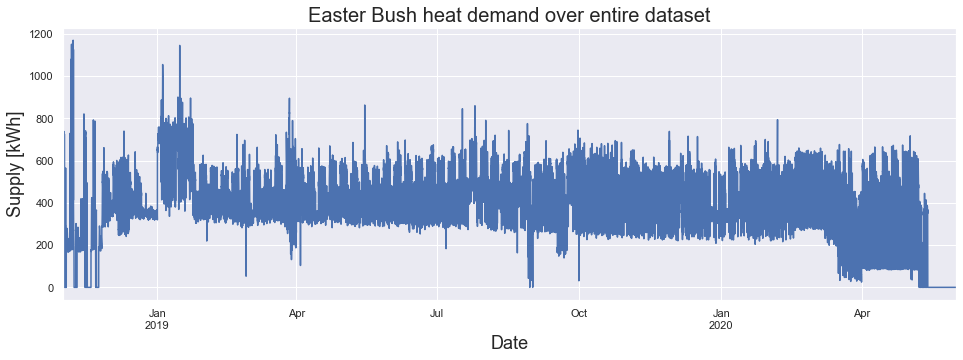

In [80]:
# Plot demand data
df3['Values'].plot(linestyle='-')
plt.title('Easter Bush heat demand over entire dataset', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Supply [kWh]', fontsize=18)

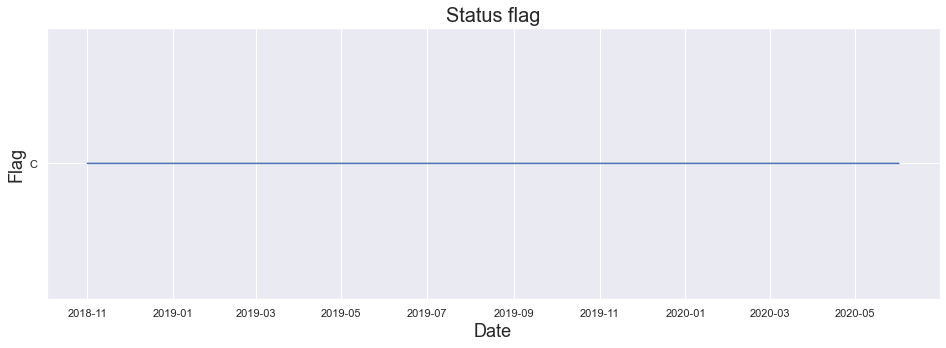

In [81]:
# Plot status flags
plt.plot(df3['Status'])
plt.title('Status flag', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Flag', fontsize=18)
plt.show()  

Text(0, 0.5, 'Supply [kWh]')

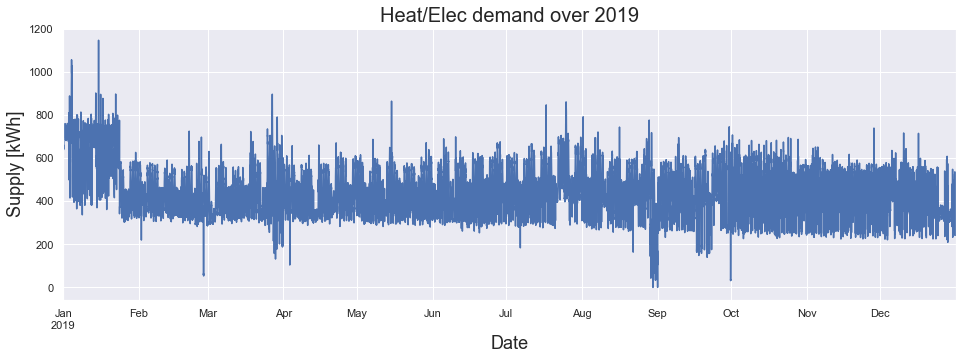

In [82]:
# Plot demand data over 2019
df3.loc['2019', 'Values'].plot(linestyle='-')
plt.title('Heat/Elec demand over 2019', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Supply [kWh]', fontsize=18)

Text(0, 0.5, 'Supply [kWh]')

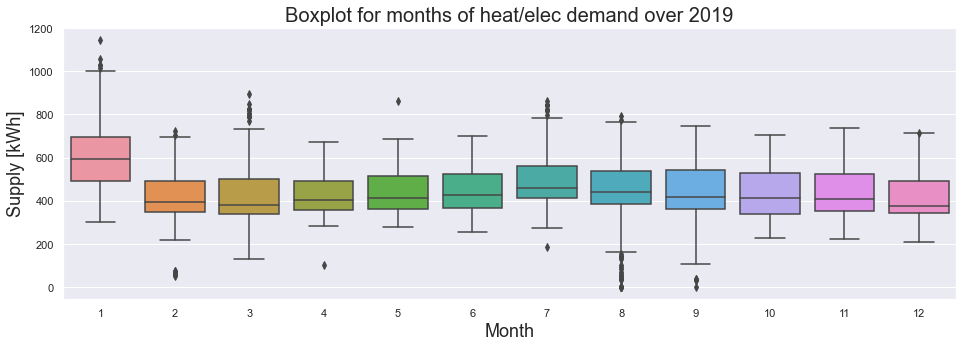

In [83]:
# Box plots over 2019 for month values
fig, ax = plt.subplots()
sns.boxplot(data=df3.loc['2019'], x='Month', y='Values')
ax.set_title('Boxplot for months of heat/elec demand over 2019', fontsize=20)
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Supply [kWh]', fontsize=18)

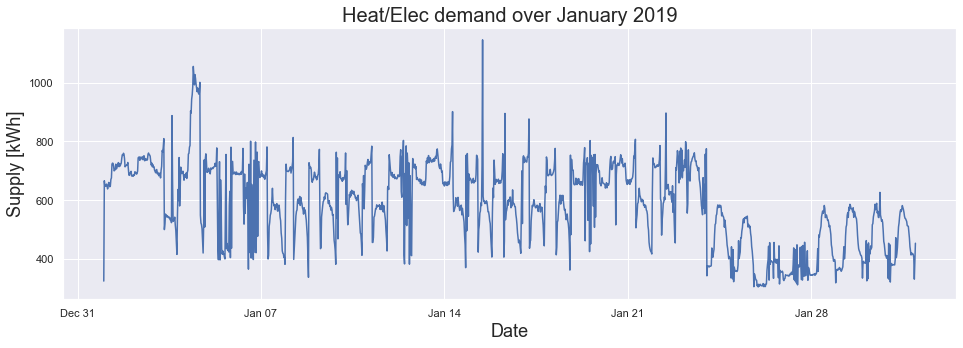

In [84]:
# Plot demand data over Jan 2019
fig, ax = plt.subplots()
ax.plot(df3.loc['2019-01', 'Values'], linestyle='-')
ax.set_title('Heat/Elec demand over January 2019', fontsize=20)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Supply [kWh]', fontsize=18)
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

### Add air temperature data to the dataframe

In [85]:
# Adding in a air temperature for 2019 to the data series
# Set path to the current directory
cwd = os.getcwd()
    
# Define path of the data file
filename = 'edinburgh_air_temp_ninja_2019.csv'
absolute_path = os.path.join(cwd, 'UoE_energy_data', 'UoE_energy_data',filename)

# Read data and parse the date
df_air_temp = pd.read_csv(absolute_path, parse_dates=True, date_parser=try_parsing_date, skiprows=3)

# Remove all but the time columns
df_air_temp_2 = df_air_temp[['temperature']]
idx = pd.date_range("2019-01-01", periods=8760, freq="H")
df_air_temp_2.index = idx

#upsample to 0.5H readings using linear interpolation
df_air_temp_3 = df_air_temp_2.resample('0.5H').asfreq()
df_air_temp_3 = df_air_temp_3.interpolate(method='linear')

# add as column to other dataframe
df3['temperature'] = df_air_temp_3['temperature']

# the last value of 2019 is missing, fill with the previous value
df3.at['2019-12-31 23:30:00', 'temperature'] = df_air_temp_3['temperature']['2019-12-31 23:00:00']

# print 5 random values
df3.loc['2019'].sample(5, random_state=0)

,Values,Status,Year,Month,temperature
2019-05-31 07:00:00,489.7,C,2019,5,12.834
2019-07-23 05:00:00,421.9,C,2019,7,15.880
2019-08-20 21:30:00,378.4,C,2019,8,10.582
2019-06-29 19:00:00,449.4,C,2019,6,18.163
2019-06-10 13:30:00,581.6,C,2019,6,14.505


Text(0, 0.5, 'Temperature')

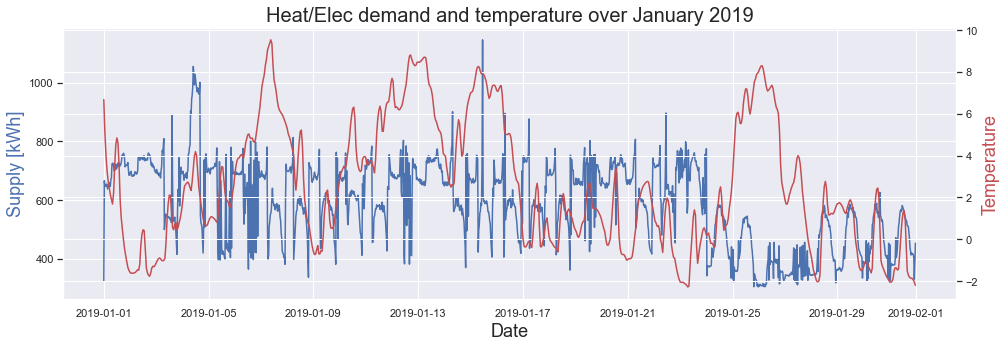

In [86]:
# Plot demand and temperature data over Jan 2019
fig, ax = plt.subplots()
ax.plot(df3.loc['2019-01', 'Values'], linestyle='-')
ax2 = ax.twinx()
ax2.plot(df3.loc['2019-01', 'temperature'], linestyle='-', color="r")
ax.set_title('Heat/Elec demand and temperature over January 2019', fontsize=20)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Supply [kWh]', fontsize=18, color='b')
ax2.set_ylabel('Temperature', fontsize=18, color='r')

### Calculate correlation coefficient between demand and temperature

In [87]:
# correlation between supply and temperature, pandas calculates the pearson r by default
df3.loc['2019', 'Values'].corr(df3.loc['2019', 'temperature'])

0.17512471834230425

### Perform linear regression analysis

C:\Users\s2216495\AppData\Local\Temp/ipykernel_15144/3333775592.py:2: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



Text(0, 0.5, 'Supply [kWh]')

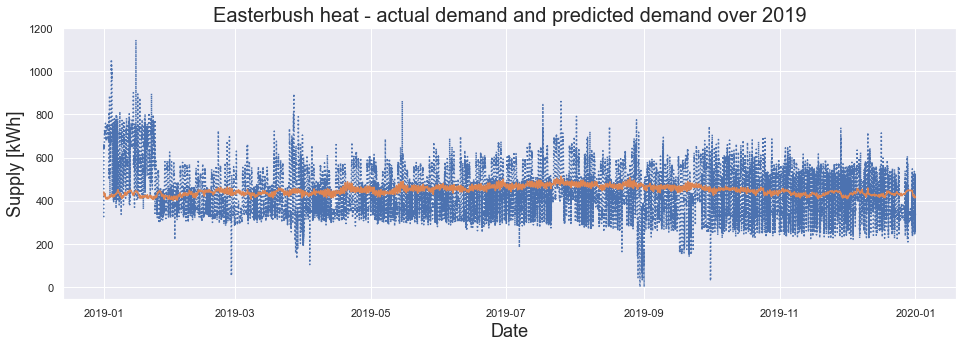

In [88]:
#linear regression
data = df3['2019']
X = df3.loc['2019', 'temperature'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df3.loc['2019', 'Values'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

# transform predictions into a dataseries
idx = pd.date_range("2019-01-01", periods=17520, freq="0.5H")
Y_ds = pd.Series(Y_pred.flatten(), index=idx)
# put demand predictions into original dataframe
df3['demand_prediction'] = Y_ds

# Plot demand data and demand predictions over 2019
fig, ax = plt.subplots()
ax.plot(df3.loc['2019', 'Values'], linestyle='dotted')
ax.plot(df3.loc['2019', 'demand_prediction'], linestyle='-')
ax.set_title('Easterbush heat - actual demand and predicted demand over 2019', fontsize=20)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Supply [kWh]', fontsize=18)

### Energy storage requirements

In [66]:
# average value of the demand
data = df3['2019']
mean_value = data['Values'].mean()
data['Mean Demand'] = mean_value
data['Values'].mean()

C:\Users\s2216495\AppData\Local\Temp/ipykernel_15144/995604046.py:2: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

C:\Users\s2216495\AppData\Local\Temp/ipykernel_15144/995604046.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



468.84703193893

Text(0, 0.5, 'Supply [kWh]')

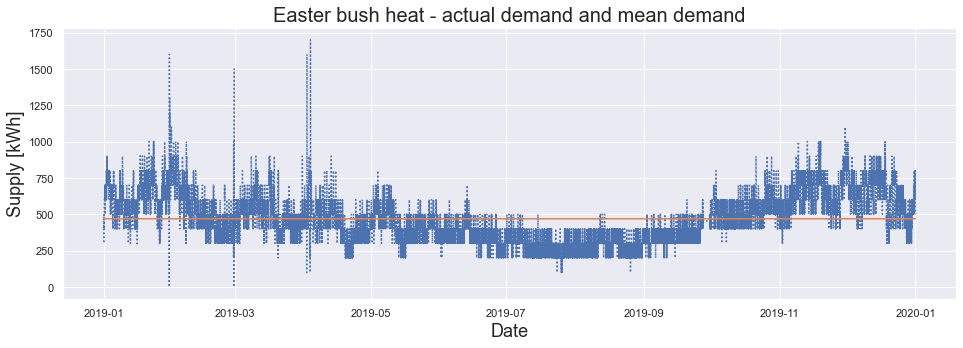

In [67]:
# Plot demand data and demand predictions over 2019
fig, ax = plt.subplots()
ax.plot(df3.loc['2019', 'Values'], linestyle='dotted')
ax.plot(data['Mean Demand'], linestyle='-')
ax.set_title('Easter bush heat - actual demand and mean demand', fontsize=20)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Supply [kWh]', fontsize=18)

In [51]:
storage_to_flatten = df3.loc[df3['Values'] > data['Values'].mean(), 'Values'].sum()
 
print(storage_to_flatten / 1000000, 'Storage to flatten the demand curve (GWh)')

9.33119799897 Storage to flatten the demand curve (GWh)


### PyPSA modeling

In [70]:
df3.index[-1]

Timestamp('2020-05-15 00:00:00')

In [92]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import Constraint
plt.style.use('bmh')

In [25]:
override_component_attrs = pypsa.descriptors.Dict(
    {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
)
override_component_attrs["Link"].loc["bus2"] = [
    "string",
    np.nan,
    np.nan,
    "2nd bus",
    "Input (optional)",
]
override_component_attrs["Link"].loc["efficiency2"] = [
    "static or series",
    "per unit",
    1.0,
    "2nd bus efficiency",
    "Input (optional)",
]
override_component_attrs["Link"].loc["p2"] = [
    "series",
    "MW",
    0.0,
    "2nd bus output",
    "Output",
]

In [45]:
print(os.getcwd())
pv = pd.read_csv(os.path.join(os.getcwd(), 'UoE_energy_data', 'UoE_energy_data', 'edinburgh_air_temp_ninja_2019.csv'))
pv.columns = pv.iloc[2]
pv = pv.iloc[3:]
pv = pv.reset_index()
pv = pv.set_index('local_time')
pv = pv[['temperature']]
pv.index.name = 'time'
pv['temperature'] = pv.temperature.apply(lambda entry: float(entry))
pv['temperature'] = (pv.temperature - pv.temperature.min()) / pv.temperature.max()

pv.head()

c:\Users\s2216495\Desktop\pypsa_gb\PyPSA-GB\data


2,temperature
time,
01/01/2019 00:00,0.391936
01/01/2019 01:00,0.330638
01/01/2019 02:00,0.288404
01/01/2019 03:00,0.259259
01/01/2019 04:00,0.240545


In [170]:

from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv())
data_path = os.environ.get('PROJECT_DATA')

def get_easter_bush_demand(normalize=False):
    '''
    Obtains time series of electricity and heat demand 

    Args:
        normalize(bool): Default False, 

    '''

    elec_demand = os.path.join(data_path, 'UoE_energy_data', 
                    'UoE_energy_data', 'AMR_Data_for_meter_0795NE003V_Easter Bush Elec.XLSX') 
    heat_demand = os.path.join(data_path, 'UoE_energy_data', 
                    'UoE_energy_data', 'AMR_Data_for_meter_0795NH001S_Easter Bush Heat.XLSX') 

    # Read data and parse the date
    df_elec = pd.read_excel(elec_demand, parse_dates=True, date_parser=try_parsing_date, index_col='(Data is in GMT Format)')
    df_elec = df_elec.rename(columns=lambda x: x.strip())  # some column names begin with a space

    # Read data and parse the date
    df_heat = pd.read_excel(heat_demand, parse_dates=True, date_parser=try_parsing_date, index_col='(Data is in GMT Format)')
    df_heat = df_heat.rename(columns=lambda x: x.strip())  # some column names begin with a space

    def fix_df_shape(df):
        # Remove all but the time columns
        df2 = df.filter(df.columns[5:5+48], axis=1)

        #convert all times to timedelta
        df2.columns = pd.to_timedelta(df2.columns + ':00')

        # Stack and change index from date to datetime
        df_st = df2.stack()
        df_st = pd.DataFrame(df_st) 
        df_st.index = df_st.index.get_level_values(0) + df_st.index.get_level_values(1)
        df_st.columns = ['Values']

        return df_st

    # Check dataframe
    df_heat = fix_df_shape(df_heat)
    df_elec = fix_df_shape(df_elec)

    if normalize:
        df_heat['Values'] = (df_heat.Values - df_heat.Values.min()) / df_heat.Values.max()
        df_elec['Values'] = (df_elec.Values - df_elec.Values.min()) / df_elec.Values.max()


    return df_heat, df_elec


In [260]:
# load elec prices data

def get_elec_prices(freq, show=False):

    eprices = os.path.join(data_path, 'UoE_energy_data', 'agileout.csv')
    eprices = pd.read_csv(eprices, parse_dates=True, header=None, index_col=0)

    eprices = eprices.rename(columns={4: 'price'})
    eprices = eprices[['price']]

    if show:
        fig, ax = plt.subplots(1, 1, figsize=(16, 4))
        eprices.iloc[-2000:].plot(ax=ax)
        plt.show()

    eprices = eprices.resample(freq).mean()
    eprices.index = eprices.index - pd.Timedelta(weeks=52)

    return eprices


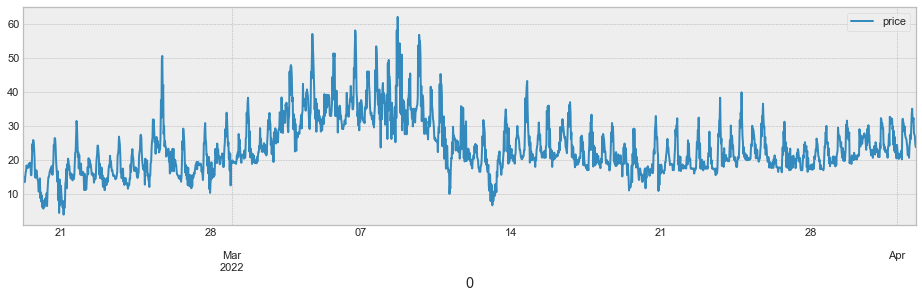

,price
0,
2018-05-16 23:00:00+00:00,3.96
2018-05-16 23:30:00+00:00,3.91
2018-05-17 00:00:00+00:00,3.91
2018-05-17 00:30:00+00:00,3.91
2018-05-17 01:00:00+00:00,3.91
...,...
2021-04-02 19:30:00+00:00,27.75
2021-04-02 20:00:00+00:00,27.39
2021-04-02 20:30:00+00:00,26.88


In [261]:
get_elec_prices('30min', show=True)

#### Normalized analysis

In [246]:
heat, elec = get_easter_bush_demand(normalize=True)

start = pv.index[0]
end = pv.index[-1]

elec = elec.loc[start:end]
heat = heat.loc[start:end]

network = pypsa.Network()

cutoff = 500
heat_demand = heat.iloc[:cutoff].Values
elec_demand = elec.iloc[:cutoff].Values

snapshots = elec.iloc[:cutoff].index

network.snapshots = snapshots
freq = '30min'

# cost in pound per kWh
elec_mcost = get_elec_prices(freq)
elec_mcost.index = elec_mcost.index - pd.Timedelta(weeks=52)
elec_mcost = elec_mcost.loc[snapshots[0]:snapshots[-1]].price
elec_mcost.index = snapshots

gas_mcost = elec_mcost.mean() / 4.

# chp params
nom_r = 1. # ratio max heat vs max elec output
c_m = 0.75 # backpressure limit
c_v = 0.15 # marginal loss for each generation of heat
cop = 3.   # coefficient of performance of the heat pump

network.add('Carrier', 'elec')
network.add('Carrier', 'gas', co2_emissions=0.2)
network.add('Carrier', 'heat')

# demand
network.add('Bus', 'heatloadbus', carrier='gas')
network.add('Bus', 'elecloadbus', carrier='elec')
network.add('Load', 'heatload', bus='heatloadbus', p_set=heat_demand)
network.add('Load', 'elecload', bus='elecloadbus', p_set=elec_demand)

# electricity market
network.add('Bus', 'elecmarketbus', carrier='elec')
network.add('Generator', 'elecmarket', bus='elecmarketbus', marginal_cost=elec_mcost, p_nom=1.) 
network.add('Link', 'elecmarket2elecload', bus0='elecmarketbus', bus1='elecloadbus', p_nom=1.)

# chp
network.add('Bus', 'gasmarket_chp_bus', carrier='gas')
network.add('Generator', 'gasmarket_chp', bus='gasmarket_chp_bus', carrier='gas', marginal_cost=gas_mcost, p_nom=1, 
                                      ramp_limit_up=0.0005, ramp_limit_down=0.0005) # hacky way to put ramp limits on chp
network.add('Link', 'chp2heat', bus0='gasmarket_chp_bus', bus1='heatloadbus', efficiency=0.9, p_nom_extendable=True)
network.add('Link', 'chp2elec', bus0='gasmarket_chp_bus', bus1='elecloadbus', efficiency=0.468, p_nom_extendable=True)
# proportionality between elec and heat generation will be ensured by extra_functionality

# boiler
network.add('Bus', 'gasmarket_boiler_bus', carrier='heat')
network.add('Generator', 'gasmarket_boiler', bus='gasmarket_boiler_bus', marginal_cost=gas_mcost, p_nom=2)
network.add('Link', 'boiler', bus0='gasmarket_boiler_bus', bus1='heatloadbus', efficiency=0.9, p_nom=2.)   # efficiency?

# store
network.add('Bus', 'storebus', carrier='heat')
network.add('Store', 'store', bus='storebus', carrier='heat', e_nom=len(network.snapshots))
network.add('Link', 'store2heatload', bus0='storebus', bus1='heatloadbus', efficiency=0.9, p_nom=1.)
network.add('Link', 'heatpump', bus0='elecmarketbus', bus1='storebus', efficiency=cop, p_nom=1.)


# Guarantees ISO fuel lines, i.e. fuel consumption p_b0 + p_g0 = constant along p_g1 + c_v p_b1 = constant
network.links.at["chp2heat", "efficiency"] = (
     network.links.at["chp2elec", "efficiency"] / c_v
)

def extra_functionality(network, snapshots):

    # Guarantees heat output and electric output nominal powers are proportional
    network.model.chp_nom = Constraint(
        rule=lambda model: network.links.at["chp2elec", "efficiency"]
        * nom_r
        * model.link_p_nom["chp2elec"]
        == network.links.at["chp2heat", "efficiency"] * model.link_p_nom["chp2heat"]
    )

    # Guarantees c_m p_b1  \leq p_g1
    def backpressure(model, snapshot):
        return (
            c_m
            * network.links.at["chp2heat", "efficiency"]
            * model.link_p["chp2heat", snapshot]
            <= network.links.at["chp2elec", "efficiency"]
            * model.link_p["chp2elec", snapshot]
        )

    network.model.backpressure = Constraint(list(snapshots), rule=backpressure)

    # Guarantees p_g1 +c_v p_b1 \leq p_g1_nom
    def top_iso_fuel_line(model, snapshot):
        return (
            model.link_p["chp2heat", snapshot] + model.link_p["chp2elec", snapshot]
            <= model.link_p_nom["chp2elec"]
        )

    network.model.top_iso_fuel_line = Constraint(
        list(snapshots), rule=top_iso_fuel_line
    )


network.lopf(solver_name='gurobi', extra_functionality=extra_functionality)

C:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x5503
  Lower bound: 1753.4182734430522
  Upper bound: 1753.4182734430522
  Number of objectives: 1
  Number of constraints: 11500
  Number of variables: 5503
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 5503
  Number of nonzeros: 20998
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message:

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

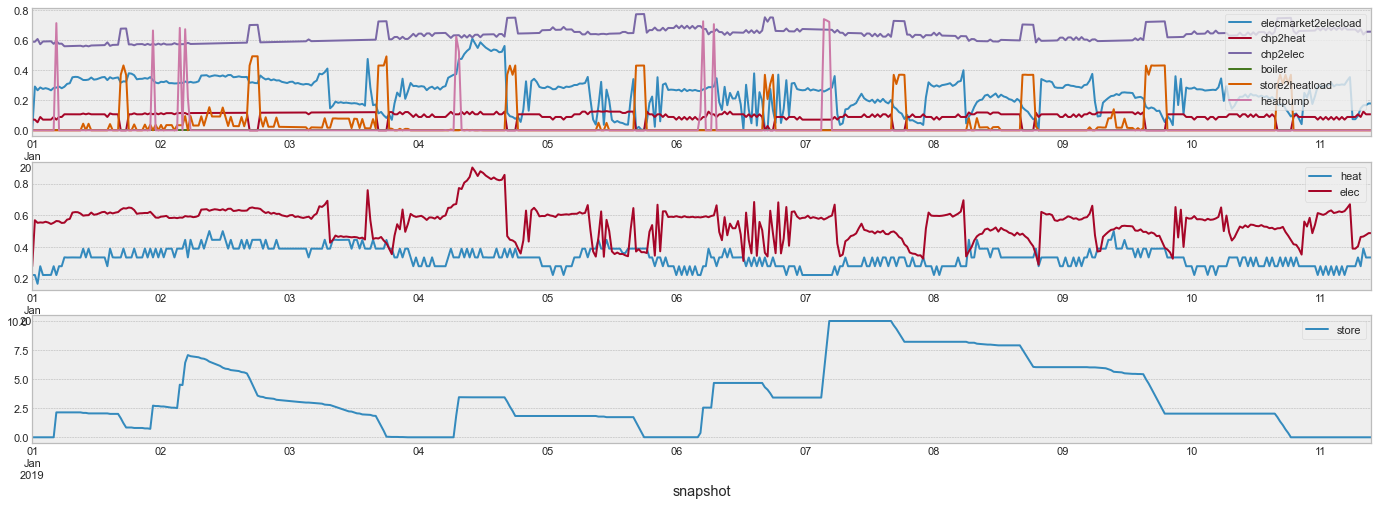

In [247]:
fig, ax = plt.subplots(3, 1, figsize=(24, 8))
network.links_t.p0.plot(ax=ax[0])

heat_demand.plot(ax=ax[1], label='heat')
elec_demand.plot(ax=ax[1], label='elec')

network.stores_t.e.plot(ax=ax[2])

for a in ax:
    a.legend()

plt.show()

### True Value analysis

In [262]:
heat, elec = get_easter_bush_demand()

start = pv.index[0]
end = pv.index[-1]

elec = elec.loc[start:end]
heat = heat.loc[start:end]

network = pypsa.Network()

cutoff = 10000
heat_demand = heat.iloc[:cutoff].Values
elec_demand = elec.iloc[:cutoff].Values

snapshots = elec.iloc[:cutoff].index

network.snapshots = snapshots
freq = '30min'

# cost in pound per kWh
elec_mcost = get_elec_prices(freq)
elec_mcost.index = elec_mcost.index - pd.Timedelta(weeks=52)
elec_mcost = elec_mcost.loc[snapshots[0]:snapshots[-1]].price
elec_mcost.index = snapshots

gas_mcost = elec_mcost.mean() / 4.

# chp params
nom_r = 1. # ratio max heat vs max elec output
c_m = 0.75 # backpressure limit
c_v = 0.15 # marginal loss for each generation of heat
cop = 3.   # coefficient of performance of the heat pump

network.add('Carrier', 'elec')
network.add('Carrier', 'gas', co2_emissions=0.2)
network.add('Carrier', 'heat')

# demand
network.add('Bus', 'heatloadbus', carrier='gas')
network.add('Bus', 'elecloadbus', carrier='elec')
network.add('Load', 'heatload', bus='heatloadbus', p_set=heat_demand)
network.add('Load', 'elecload', bus='elecloadbus', p_set=elec_demand)

# electricity market
network.add('Bus', 'elecmarketbus', carrier='elec')
network.add('Generator', 'elecmarket', bus='elecmarketbus', marginal_cost=elec_mcost, p_nom_extendable=True) 
network.add('Link', 'elecmarket2elecload', bus0='elecmarketbus', bus1='elecloadbus', p_nom=elec_demand.max())

'''
# chp
network.add('Bus', 'gasmarket_chp_bus', carrier='gas')
network.add('Generator', 'gasmarket_chp', bus='gasmarket_chp_bus', carrier='gas', marginal_cost=gas_mcost, p_nom=1, 
                                      ramp_limit_up=0.0005, ramp_limit_down=0.0005) # hacky way to put ramp limits on chp
network.add('Link', 'chp2heat', bus0='gasmarket_chp_bus', bus1='heatloadbus', efficiency=0.9, p_nom_extendable=True)
network.add('Link', 'chp2elec', bus0='gasmarket_chp_bus', bus1='elecloadbus', efficiency=0.468, p_nom_extendable=True)
# proportionality between elec and heat generation will be ensured by extra_functionality
'''

# boiler
network.add('Bus', 'gasmarket_boiler_bus', carrier='heat')
network.add('Generator', 'gasmarket_boiler', bus='gasmarket_boiler_bus', marginal_cost=gas_mcost, p_nom_extendable=True)
network.add('Link', 'boiler', bus0='gasmarket_boiler_bus', bus1='heatloadbus', efficiency=0.9, 
                p_nom=network.generators.loc['gasmarket_boiler'].efficiency / 0.9)   # efficiency?

# store
network.add('Bus', 'storebus', carrier='heat')
network.add('Store', 'store', bus='storebus', carrier='heat', e_nom=48*heat_demand.max())
network.add('Link', 'store2heatload', bus0='storebus', bus1='heatloadbus', efficiency=0.9, p_nom=heat_demand.max() / 0.9)
network.add('Link', 'heatpump', bus0='elecmarketbus', bus1='storebus', efficiency=cop, p_nom=heat_demand.max() / cop)

'''
# Guarantees ISO fuel lines, i.e. fuel consumption p_b0 + p_g0 = constant along p_g1 + c_v p_b1 = constant
network.links.at["chp2heat", "efficiency"] = (
     network.links.at["chp2elec", "efficiency"] / c_v
)

def extra_functionality(network, snapshots):

    # Guarantees heat output and electric output nominal powers are proportional
    network.model.chp_nom = Constraint(
        rule=lambda model: network.links.at["chp2elec", "efficiency"]
        * nom_r
        * model.link_p_nom["chp2elec"]
        == network.links.at["chp2heat", "efficiency"] * model.link_p_nom["chp2heat"]
    )

    # Guarantees c_m p_b1  \leq p_g1
    def backpressure(model, snapshot):
        return (
            c_m
            * network.links.at["chp2heat", "efficiency"]
            * model.link_p["chp2heat", snapshot]
            <= network.links.at["chp2elec", "efficiency"]
            * model.link_p["chp2elec", snapshot]
        )

    network.model.backpressure = Constraint(list(snapshots), rule=backpressure)

    # Guarantees p_g1 +c_v p_b1 \leq p_g1_nom
    def top_iso_fuel_line(model, snapshot):
        return (
            model.link_p["chp2heat", snapshot] + model.link_p["chp2elec", snapshot]
            <= model.link_p_nom["chp2elec"]
        )

    network.model.top_iso_fuel_line = Constraint(
        list(snapshots), rule=top_iso_fuel_line
    )
'''

network.lopf(solver_name='gurobi')
# network.lopf(solver_name='gurobi', extra_functionality=extra_functionality)

C:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x80003_copy
  Lower bound: 48732295.946973674
  Upper bound: 48732295.946973674
  Number of objectives: 1
  Number of constraints: 180001
  Number of variables: 80003
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 80003
  Number of nonzeros: 280000
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

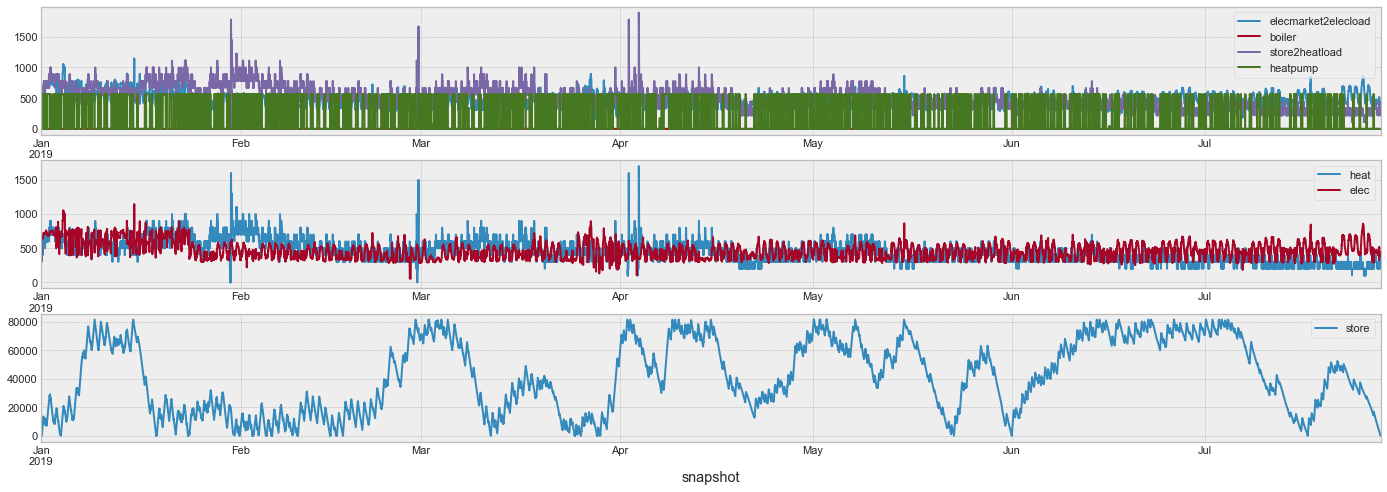

In [263]:
fig, ax = plt.subplots(3, 1, figsize=(24, 8))
network.links_t.p0.plot(ax=ax[0])

heat_demand.plot(ax=ax[1], label='heat')
elec_demand.plot(ax=ax[1], label='elec')

network.stores_t.e.plot(ax=ax[2])

for a in ax:
    a.legend()

plt.show()